In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2

# Define the transformations to apply to the CIFAR-10 data
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

download = True
# Define the training and test datasets
train_dataset = datasets.VOCDetection(root='../../data', image_set="train", download=download, transform=data_transforms)

# Define the dataloaders to load the data in batches during training and testing
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader = train_loader

100.0%


Extracting ../../data/VOCtrainval_11-May-2012.tar to ../../data


OSError: [Errno 122] Disk quota exceeded: '../../data/VOCdevkit/VOC2012/JPEGImages/2012_001405.jpg'

In [4]:
!rm -rf ../../data

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [2]:
# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()
        
        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            )
            self.encoders.append(encoder)

            decoder = nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
                nn.Tanh()
            )
            self.decoders.append(decoder)
            
            channel_reducer = nn.Conv2d(3, 256, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)
            
            
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)
        #self.downsamplers.append(downsampler)
            
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        #self.upsamplers.append(upsampler)

    def forward(self, x):
        # Initialize list to store features from each scale
        features = []

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #downsample = nn.Upsample(scale_factor=1/scale_factor**i, mode='bilinear', align_corners=False)
            x = self.downsampler(x)
            #x = nn.functional.max_pool2d(encoder_output, kernel_size=2, stride=2)

#         # Concatenate features from all scales
#         concatenated_features = torch.cat(features, dim=1)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = torch.zeros(shape_feats).to(device)
        
#         for f in features:
#             print(f.shape)
        
        for i in range(self.num_scales):
            prev_output = self.channel_reducers[i](prev_output)
            #print(i, prev_output.shape, features[self.num_scales - i - 1].shape)
            prev_output += features[self.num_scales - i - 1]#features[self.num_scales - i - 1]
            decoder_output = self.decoders[i](prev_output)
            #features.append(encoder_output)
            #upsampler = nn.Upsample(scale_factor=scale_factor**i, mode='bilinear', align_corners=False)
            if i+1< self.num_scales:
                prev_output = self.upsampler(decoder_output)
            #x = nn.functional.max_pool2d(encoder_output, kernel_size=2, stride=2)

#         decoded = self.decoders[0](concatenated_features)
        #print(decoder_output.shape)
        return decoder_output


In [3]:
# model = CompletionModel().to(device)

# # Define the loss function
# criterion = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [4]:
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [5]:
from IPython.display import display, HTML

# # Define test transformations
# test_transform = Compose([
#     ToTensor()
# ])
test_dataset = datasets.Flowers102(root='../curriculum-learning/data', split="test", download=download, transform=data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Load CIFAR-10 test dataset
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# # Create test data loader
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    i = 0
    for images, _ in test_dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        
        ########
        
        # Generate completions using the model
        completions = model(occluded_image.to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        original_img = to_pil(occluded_image.cpu().squeeze(0))
        completed_img = to_pil(completions.cpu().squeeze(0))
        
        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"
        i+=1
        if i==3:
            break

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

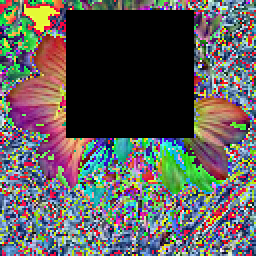

In [8]:
from PIL import Image
original_img.resize((original_img.width * 2,original_img.height * 2),
                                                    Image.NEAREST)


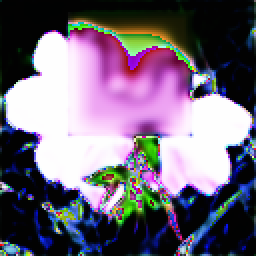

In [9]:
completed_img.resize((completed_img.width * 2,completed_img.height * 2),
                                                    Image.NEAREST)

## Downstream evaluation

In the SSL model trained above, we have multiple encoders. All of these specialize in capturing the information at a specific level.

In [43]:
# torch.save(model.state_dict(), 'ssl_model.pth')

In [6]:
model.load_state_dict(torch.load('ssl_model.pth'))

<All keys matched successfully>

In [44]:
# nn.Sequential(model.encoders[0], nn.Flatten(), nn.C))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=256, out_features=1, bias=True)
)

In [51]:
# model.encoders[2](torch.randn(1, 3, 128, 128).cuda()).shape

torch.Size([1, 256, 128, 128])

In [13]:
input_shape = (256, 128, 128)
# Define the classification model
classification_model = nn.Sequential(
    # Convolutional layers
    nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),

#     # Flatten the feature maps
    nn.Flatten(),
    nn.Dropout(),
#     # Fully connected layers
    nn.Linear(256 * 16*16, 1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024, 102)  # num_classes is the number of classes for classification
)

# Print the classification model architecture
print(classification_model)

Sequential(
  (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=65536, out_features=1024, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=1024, out_features=102, bias=True)
)


In [14]:
# classification_model.cuda()(model.encoders[2](torch.randn(1, 3, 128, 128).cuda())).shape
# torch.cuda.empty_cache()

In [15]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate, weight_decay=0.001)

In [16]:
def model_eval(model, classification_model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            #outputs = model(images)
            outputs = classification_model.cuda()(model.encoders[2](images))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model = classification_model.to(device)

log_train_every = 1
log_test_every = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        #outputs = model(inputs)
        outputs = classification_model.cuda()(model.encoders[2](inputs))
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # compute training & testing accuracy every couple of iterations        
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        
    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        
# writer.close()
print("Training finished.")

Epoch 1 : Loss: 99.91639947891235 Accuracy: 13.431372549019608
Epoch 1 : Test Accuracy: 1.6588063099691006
Epoch 2 : Loss: 73.51753616333008 Accuracy: 33.333333333333336
Epoch 2 : Test Accuracy: 2.5532606927955763
Epoch 3 : Loss: 46.0807865858078 Accuracy: 64.50980392156863
Epoch 3 : Test Accuracy: 3.512766303463978
Epoch 4 : Loss: 21.646090149879456 Accuracy: 83.92156862745098
Epoch 4 : Test Accuracy: 3.8542852496340867
Epoch 5 : Loss: 10.291690200567245 Accuracy: 92.84313725490196
Epoch 5 : Test Accuracy: 3.7567084078711988
Epoch 6 : Loss: 5.119639813899994 Accuracy: 93.82352941176471
Epoch 6 : Test Accuracy: 3.870548056594568
Epoch 7 : Loss: 3.0966795682907104 Accuracy: 96.17647058823529
